# U-Net Architecture Pipeline for Vertebrae segmentation (vertebrae full bodies segmentation)

## Preparation step

### Dataset folder tree
```
V&F_Dataset:.
├───originals
│   ├───001
│   │       001_FD.dcm
│   │       001_SD.dcm
│   │        
│   ├───002   
│   ├───...    
│   └───099
│
└───labels
    ├───001
    │   ├───001_FD
    │   │       C1.mrk.json
    │   │       ...
    │   │       FH2.mrk.json
    │   │   
    │   ├───001_SD
    │   │       C1.mrk.json
    │   │       ...
    │   │       FH2.mrk.json
    │   │
    │   ├───point
    │   │       001.png
    │   │       
    │   └───fill
    │           001.png
    │           
    ├───002
    ├───...
    └───099
```


In [ ]:
print("optimal image size: 4736 1920")
w = 1920
h = 4736
sizes = [(h, w), (h//2, w//2), (h//4, w//4), (h//8, w//8)]
print(sizes[0], sizes[1], sizes[2], sizes[3])

optimal image size: 4736 1920
(4736, 1920) (2368, 960) (1184, 480) (592, 240)


In [ ]:
import wandb
import albumentations
import torch
import os
from  functionality import *


c:\Users\gieko\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# path_to_dataset = "C:\\Users\\EUgolnikova\\Dropbox\\NIITO_Vertebrae\\NIITO_Vertebrae_Dataset\\NIITO_Vertebrae_Dataset_resized"
path_to_dataset = "C:\\Users\\gieko\\Dropbox\\NIITO_Vertebrae\\NIITO_Vertebrae_Dataset\\Ver1_ 4736x1920\\NIITO_Vertebrae_Dataset_resized"


path_to_images = os.path.join(path_to_dataset, "images")
path_to_labels = os.path.join(path_to_dataset, "labels")

path_to_train = ""
path_to_val = ""
path_to_test = ""


all_cases = os.listdir(path_to_images)
# all_cases 


# for case in all_cases:
#     image_path = os.path.join(path_to_images, *[case, case + "_SD_resized.dcm"])
#     mask_path_fill = os.path.join(path_to_labels, *[case, "fill", case + "_SD.png"])
#     mask_path_point = os.path.join(path_to_labels, *[case, "point", case + "_SD.png"])

#     image, mask_fill, dicom = read_image(image_path, mask_path_fill, channels3=False, return_dicom=True)
    # print(image.shape, mask_fill.shape)


## Split data to train and validaion sets

> Please assume there's somewhere already a folder with test data unified for every model we create

In [ ]:
import os
from sklearn.model_selection import train_test_split

In [ ]:
# train, val = train_test_split(list(range(len(all_cases))), test_size=0.3)
all_cases = all_cases
train_cases, val_cases = train_test_split(all_cases, test_size=0.3)

print(len(train_cases), len(val_cases))
# train = list(range(len(all_cases)))
# train

35 15


## Dataset 

In [ ]:
import os
import pydicom
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class DatasetNew(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return {"image": self.data[index]['image'], "mask": self.data[index]['mask']}

### Show some augs

In [ ]:
import torch
# import torchvision 
import albumentations as A
from albumentations.pytorch import ToTensorV2
import albumentations.augmentations.functional as F


# size = sizes[1]
size = (256, 256)
path_to_dataset = "C:\\Users\\gieko\\Dropbox\\NIITO_Vertebrae\\NIITO_Vertebrae_Dataset\\NIITO_Vertebrae_Dataset_Final_resized\data_single_vertebra"
path_to_images = os.path.join(path_to_dataset, "images")
path_to_labels = os.path.join(path_to_dataset, "labels")

path_to_train = ""
path_to_val = ""
path_to_test = ""


all_cases = os.listdir(path_to_images)
all_cases = all_cases
train_cases, val_cases = train_test_split(all_cases, test_size=0.3)

quality_augs = [
            A.RandomFog(fog_coef_lower=0.3, fog_coef_upper=0.4, alpha_coef=0.05, p=1), 
            A.RandomBrightnessContrast(brightness_limit=0.07, contrast_limit=0.25, p=1),
            A.RandomSnow(snow_point_lower=0.07, snow_point_upper=0.4, brightness_coeff=2.7, p=1),
            A.HueSaturationValue(hue_shift_limit=17, sat_shift_limit=40, val_shift_limit=30, p=1),
            A.CLAHE(p=1),
            A.GaussNoise(var_limit=(7.0, 27.0), mean=0, per_channel=False, p=1),
            A.Emboss(alpha=(0.2, 0.5), strength=(0.2, 0.7), p=1),
            A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=1),
        ]

rotation_augs = [
            A.Rotate(limit = (5,20), p=0.5),
            A.Rotate(limit = (340,355), p=0.5)
        ]


origs_rotared = A.ReplayCompose([
        A.Resize(height=size[0], width=size[1]),
        A.OneOf(rotation_augs, p=1),
        ToTensorV2()
    ], p=1,
    additional_targets={'image': 'image', 'mask': 'mask'})

one_effect = []
for i in quality_augs:
    print(i)
    one_effect.append(
        A.ReplayCompose([
        A.Resize(height=size[0], width=size[1]),
        i,
        ToTensorV2()
    ], p=1,
    additional_targets={'image': 'image', 'mask': 'mask'})
    )



dataset_augs =  [origs_rotared] + one_effect

val_transforms = A.ReplayCompose(
    [   
        A.Resize(height=size[0], width=size[1]),
        ToTensorV2()
    ],
    additional_targets={'image': 'image', 'mask': 'mask'})


RandomFog(always_apply=False, p=1, fog_coef_lower=0.3, fog_coef_upper=0.4, alpha_coef=0.05)
RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.07, 0.07), contrast_limit=(-0.25, 0.25), brightness_by_max=True)
RandomSnow(always_apply=False, p=1, snow_point_lower=0.07, snow_point_upper=0.4, brightness_coeff=2.7)
HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-17, 17), sat_shift_limit=(-40, 40), val_shift_limit=(-30, 30))
CLAHE(always_apply=False, p=1, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
GaussNoise(always_apply=False, p=1, var_limit=(7.0, 27.0), per_channel=False, mean=0)
Emboss(always_apply=False, p=1, alpha=(0.2, 0.5), strength=(0.2, 0.7))
Sharpen(always_apply=False, p=1, alpha=(0.2, 0.5), lightness=(0.5, 1.0))


In [ ]:
all_cases[185]

'009_SD_C4.png'

In [ ]:
from functionality import *

batch_size = 1

dataset = [[] for _ in range(len(dataset_augs))] 

valid_aug = []


case = all_cases[185]
# print(case)
path_mask = os.path.join(path_to_labels, case)
path_image = os.path.join(path_to_images, case)

image = cv2.imread(path_image, 1)
# mask = read_mask(path_mask)
mask = cv2.imread(path_mask, 0)   
mask[mask==255] = 1.0 

for i, subset in enumerate(dataset_augs):
    augmentations = subset(image=image, mask=mask)
    print(augmentations['image'].shape, augmentations['mask'].shape)
    dataset[i].append({
        "image": augmentations['image'],
        "mask": augmentations['mask']
    })


    # print(case)

mask[mask==255.0] = 1.0
# print(image.shape, mask.shape)

# image = np.moveaxis(image, 0, 2)


augmentations = val_transforms(image=image, mask=mask)
# print("!!",augmentations['image'].shape, augmentations['mask'].shape)

valid_aug.append({
    "image": augmentations['image'],
    "mask": augmentations['mask']
})


for subset in dataset:
    subset = DatasetNew(subset)

train_dataset = torch.utils.data.ConcatDataset(dataset)
train_loader =  torch.utils.data.DataLoader(train_dataset, batch_size, pin_memory=True, shuffle=True)

val_dataset = DatasetNew(valid_aug)
val_loader =  torch.utils.data.DataLoader(val_dataset, batch_size, pin_memory=True, shuffle=True)


# print(train_dataset, train_loader)
# print(train_dataset, train_loader)

# print(train_loader.__len__())
# print(val_loader.__len__())

print(train_dataset.__len__())
print(val_dataset.__len__())

torch.Size([3, 256, 256]) torch.Size([256, 256])
torch.Size([3, 256, 256]) torch.Size([256, 256])
torch.Size([3, 256, 256]) torch.Size([256, 256])
torch.Size([3, 256, 256]) torch.Size([256, 256])
torch.Size([3, 256, 256]) torch.Size([256, 256])
torch.Size([3, 256, 256]) torch.Size([256, 256])
torch.Size([3, 256, 256]) torch.Size([256, 256])
torch.Size([3, 256, 256]) torch.Size([256, 256])
torch.Size([3, 256, 256]) torch.Size([256, 256])
9
1


c:\Users\gieko\AppData\Local\Programs\Python\Python39\lib\site-packages\albumentations\core\transforms_interface.py:113: UserWarning: Rotate could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(
c:\Users\gieko\AppData\Local\Programs\Python\Python39\lib\site-packages\albumentations\core\transforms_interface.py:113: UserWarning: RandomFog could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(
c:\Users\gieko\AppData\Local\Programs\Python\Python39\lib\site-packages\albumentations\core\transforms_interface.py:113: UserWarning: GaussNoise could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(


(122, 112, 3) (122, 112)
(256, 256, 3) (256, 256) (256, 256, 3) (256, 256)
(256, 256, 3) (256, 256) (256, 256, 3) (256, 256)
(256, 256, 3) (256, 256) (256, 256, 3) (256, 256)
(256, 256, 3) (256, 256) (256, 256, 3) (256, 256)
(256, 256, 3) (256, 256) (256, 256, 3) (256, 256)
(256, 256, 3) (256, 256) (256, 256, 3) (256, 256)
(256, 256, 3) (256, 256) (256, 256, 3) (256, 256)
(256, 256, 3) (256, 256) (256, 256, 3) (256, 256)
(256, 256, 3) (256, 256) (256, 256, 3) (256, 256)


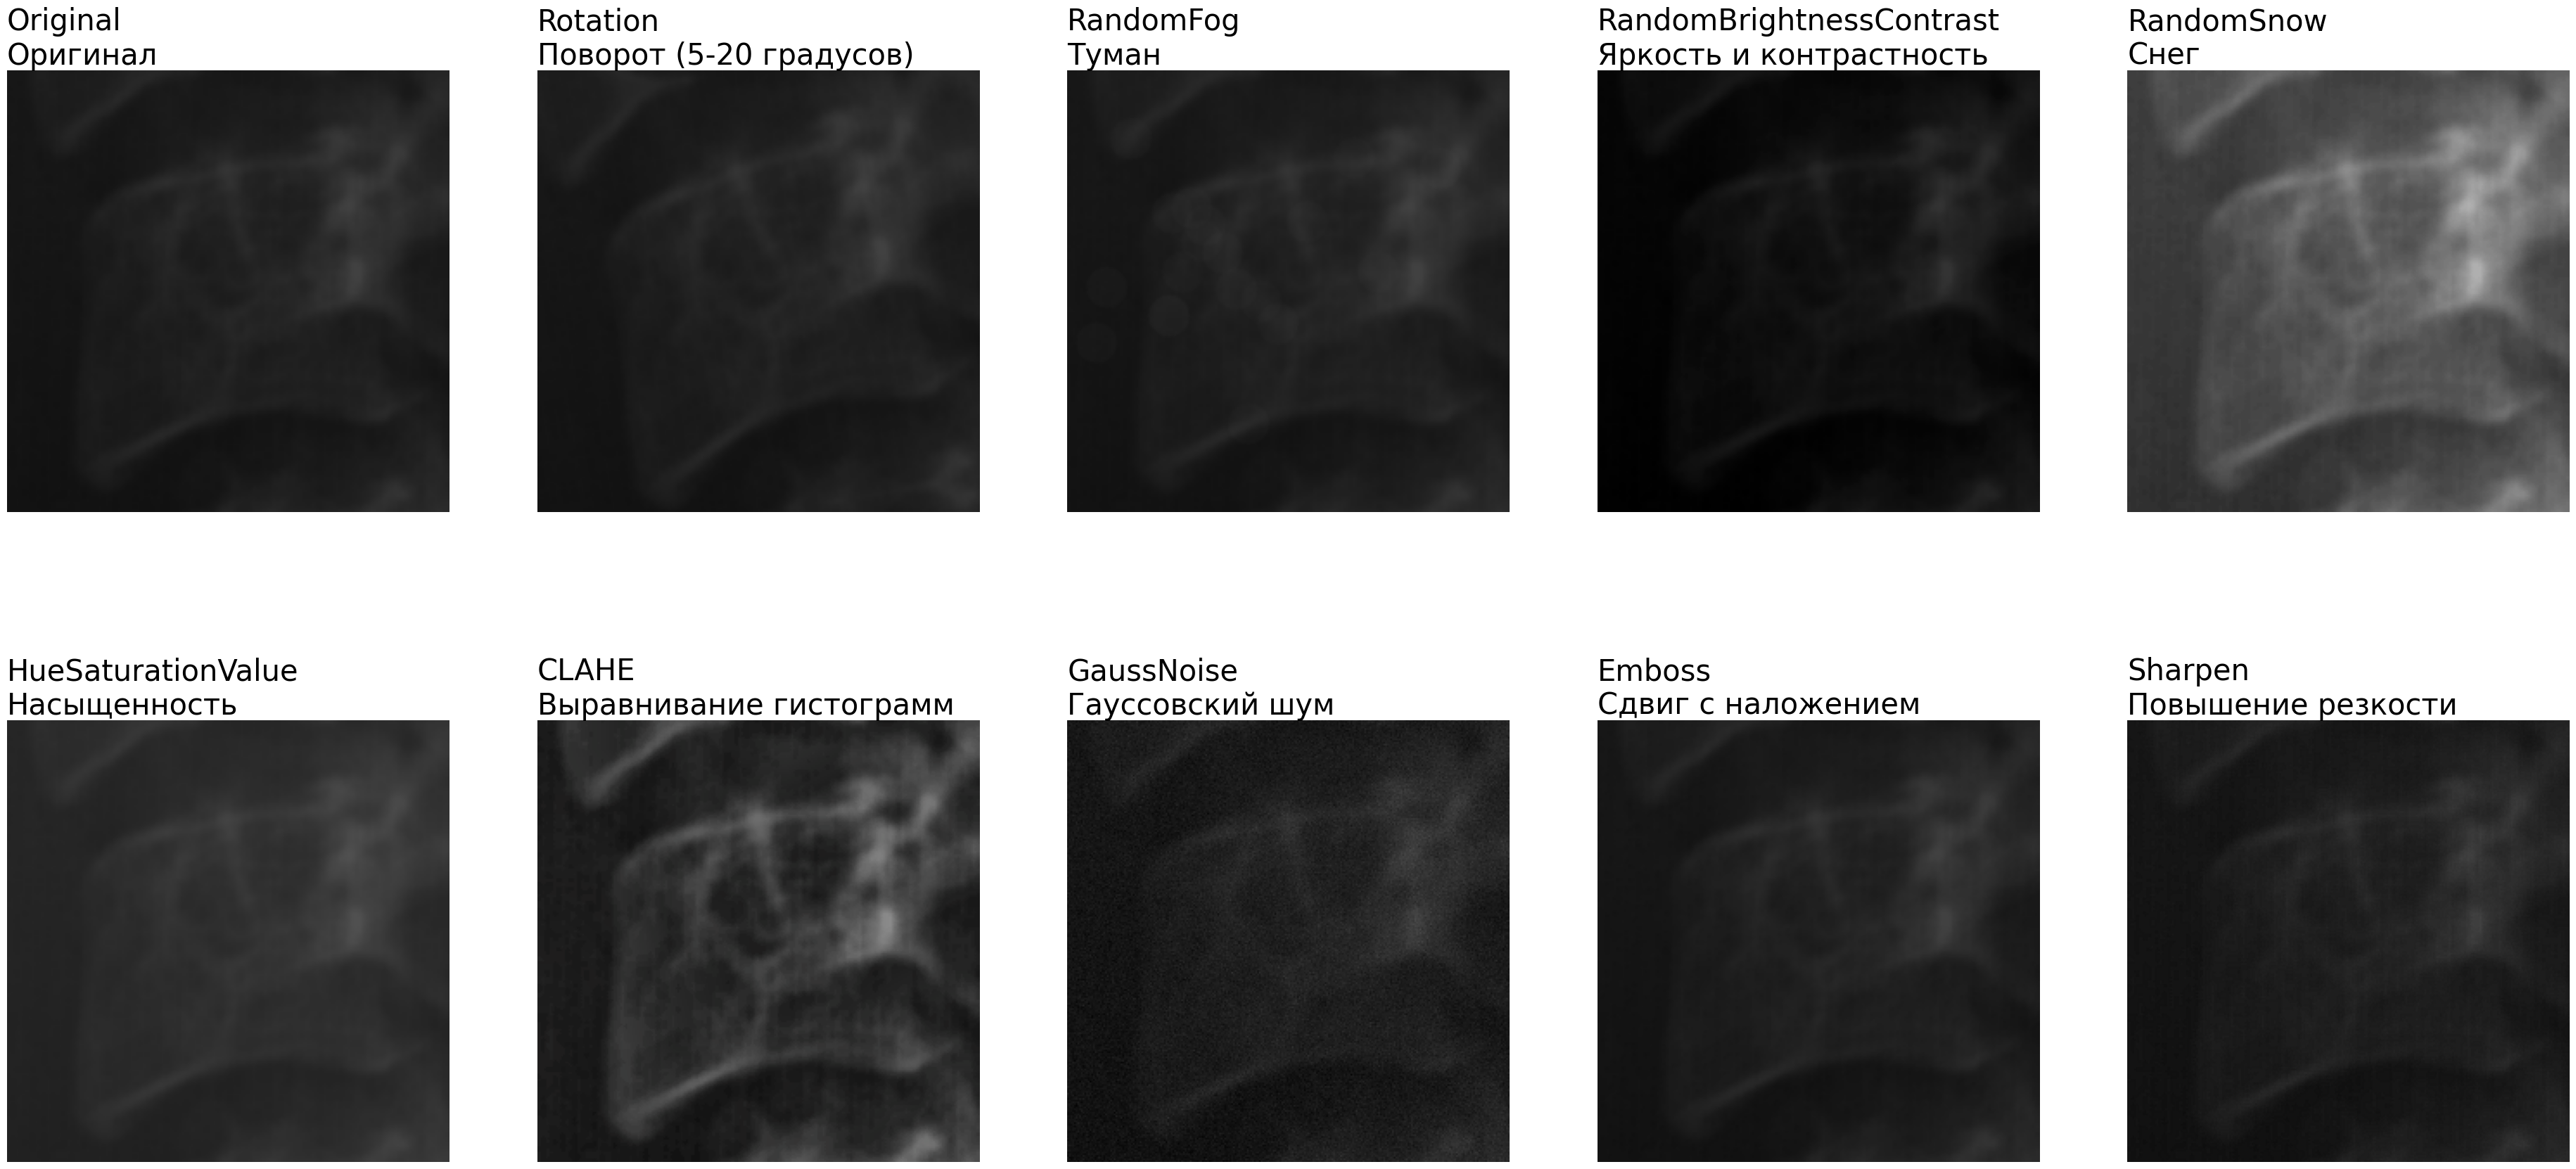

In [ ]:
import random
import matplotlib.pyplot as plt

def make_blending1(img, mask, alpha=0.5):
  colors = np.array([[0,0,0], [255,0,0]], np.uint8)
  # print("!!", img.shape, mask.shape, colors.shape)
  return (img*alpha + mask.astype(np.int32)*(1. - alpha)).astype(np.uint8)


labels = [
  "Original\nОригинал",
  "Rotation\nПоворот (5-20 градусов)", 
  "RandomFog\nТуман", 
  "RandomBrightnessContrast\nЯркость и контрастность", 
  "RandomSnow\nСнег", 
  "HueSaturationValue\nНасыщенность", 
  "CLAHE\nВыравнивание гистограмм", 
  "GaussNoise\nГауссовский шум", 
  "Emboss\nСдвиг с наложением", 
  "Sharpen\nПовышение резкости"]

orig_aug = []

# case = train_cases[278]


path_mask = os.path.join(path_to_labels, case)
path_image = os.path.join(path_to_images, case)

image = cv2.imread(path_image, 1)
# mask = read_mask(path_mask)
mask = cv2.imread(path_mask, 0)   
mask[mask==255] = 1.0 

print(image.shape, mask.shape)

orig = val_transforms(image=image, mask=mask)
orig_aug.append({
    "image": orig['image'],
    "mask": orig['mask']
})

orig_dataset = DatasetNew(orig_aug)
plt.figure(figsize = (47,22))
plt.subplot(2, 5, 1)

# print(orig_dataset[k]['image'].shape, orig_dataset[k]['mask'].shape)
clear = orig_dataset[0]['image'].permute(1, 2, 0).numpy()
clear_m = orig_dataset[0]['mask'].numpy()
plt.imshow(clear, cmap="gray")  
plt.title(labels[0], loc='left', fontsize = 30)
plt.axis('off')


for i in range(9):
  k=i
  
  plt.subplot(2, 5, i+2)
  image = train_dataset[k]['image'].permute(1, 2, 0).numpy()
  mask = train_dataset[k]['mask'].numpy()
  print(clear.shape, clear_m.shape, image.shape, mask.shape)
  plt.imshow(image, cmap="gray")
  plt.title(labels[k+1], loc='left', fontsize = 30)
  plt.axis('off')


### Define augmentations

In [ ]:
import torch
# import torchvision 
import albumentations as A
from albumentations.pytorch import ToTensorV2
import albumentations.augmentations.functional as F


size = sizes[1]

quality_augs = [
            A.RandomFog(fog_coef_lower=0.3, fog_coef_upper=0.4, alpha_coef=0.05, p=0.125), 
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2, p=0.125),
            A.RandomSnow(snow_point_lower=0.1, snow_point_upper=0.3, brightness_coeff=2.5, p=0.125),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.125),
            A.CLAHE(p=0.125),
            A.GaussNoise(var_limit=(7.0, 27.0), mean=0, per_channel=False, p=0.125),
            A.Emboss(alpha=(0.2, 0.5), strength=(0.2, 0.7), p=0.125),
            A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.125),
        ]

rotation_augs = [
            A.Rotate(limit = (5,20), p=0.5),
            A.Rotate(limit = (340,355), p=0.5)
        ]

origs = A.ReplayCompose([
        A.OneOf([
            A.Resize(height=size[0], width=size[1]),
            A.Resize(height=size[0], width=size[1])], 
            p = 1),
        
        ToTensorV2()
    ], p=1,
    additional_targets={'image': 'image', 'mask': 'mask'})

origs_rotared = A.ReplayCompose([
        A.Resize(height=size[0], width=size[1]),
        A.OneOf(rotation_augs, p=1),
        ToTensorV2()
    ], p=1,
    additional_targets={'image': 'image', 'mask': 'mask'})

one_effect = A.ReplayCompose([
        A.Resize(height=size[0], width=size[1]),
        A.OneOf(quality_augs, p=1),
        ToTensorV2()
    ], p=1,
    additional_targets={'image': 'image', 'mask': 'mask'})

one_effect_rot = A.ReplayCompose([
        A.Resize(height=size[0], width=size[1]),
        A.OneOf(quality_augs, p=1),
        A.OneOf(rotation_augs, p=1),
        ToTensorV2()
    ], p=1,
    additional_targets={'image': 'image', 'mask': 'mask'})    

two_effect = A.ReplayCompose([
        A.Resize(height=size[0], width=size[1]),
        A.OneOf(quality_augs, p=1),
        A.OneOf(quality_augs, p=1),
        ToTensorV2()
    ], p=1,
    additional_targets={'image': 'image', 'mask': 'mask'})

two_effect_rot = A.ReplayCompose([
        A.Resize(height=size[0], width=size[1]),
        A.OneOf(quality_augs, p=1),
        A.OneOf(quality_augs, p=1),
        A.OneOf(rotation_augs, p=1),
        ToTensorV2()
    ], p=1,
    additional_targets={'image': 'image', 'mask': 'mask'})

dataset_augs = [origs, origs_rotared, one_effect_rot, two_effect_rot]


val_transforms = A.ReplayCompose(
    [   
        A.Resize(height=size[0], width=size[1]),
        ToTensorV2()
    ],
    additional_targets={'image': 'image', 'mask': 'mask'})

### Create DataLoader:One size images

In [ ]:
from functionality import *

batch_size = 2

dataset = [[] for _ in range(len(dataset_augs))] 
valid_aug = []
for case in train_cases:
    # print(case)
    path_mask = os.path.join(path_to_labels, *[case, "fill_no_FH", case + "_SD.png"])
    path_image = os.path.join(path_to_images, *[case, case + "_SD_resized.dcm"])

    image, mask, _ = read_image(path_image, path_mask, channels3=True)
    print(image.shape, mask.shape)

    for i, subset in enumerate(dataset_augs):
        augmentations = subset(image=image, mask=mask)
        print(augmentations['image'].shape, augmentations['mask'].shape)
        dataset[i].append({
            "image": augmentations['image'],
            "mask": augmentations['mask']
        })

for case in val_cases:
    # print(case)
    path_mask = os.path.join(path_to_labels, *[case, "fill_no_FH", case + "_SD.png"])
    path_image = os.path.join(path_to_images, *[case, case + "_SD_resized.dcm"])
    
    image, mask, _ = read_image(path_image, path_mask, channels3=True)
    mask[mask==255.0] = 1.0
    # print(image.shape, mask.shape)

    # image = np.moveaxis(image, 0, 2)

    
    augmentations = val_transforms(image=image, mask=mask)
    print("!!",augmentations['image'].shape, augmentations['mask'].shape)

    valid_aug.append({
        "image": augmentations['image'],
        "mask": augmentations['mask']
    })


for subset in dataset:
    subset = DatasetNew(subset)

train_dataset = torch.utils.data.ConcatDataset(dataset)
train_loader =  torch.utils.data.DataLoader(train_dataset, batch_size, pin_memory=True, shuffle=True)

val_dataset = DatasetNew(valid_aug)
val_loader =  torch.utils.data.DataLoader(val_dataset, batch_size, pin_memory=True, shuffle=True)


# print(train_dataset, train_loader)
# print(train_dataset, train_loader)

# print(train_loader.__len__())
# print(val_loader.__len__())

print(train_dataset.__len__())
print(val_dataset.__len__())




(4736, 1920, 3) (4736, 1920)
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 2368, 960]) torch.Size([2368, 960])


c:\Users\gieko\AppData\Local\Programs\Python\Python39\lib\site-packages\albumentations\core\transforms_interface.py:113: UserWarning: Rotate could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(
c:\Users\gieko\AppData\Local\Programs\Python\Python39\lib\site-packages\albumentations\core\transforms_interface.py:113: UserWarning: RandomFog could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(


torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
(4736, 1920, 3) (4736, 1920)
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
(4736, 1920, 3) (4736, 1920)
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
(4736, 1920, 3) (4736, 1920)
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
(4736, 1920, 3) (4736, 1920)
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 23

c:\Users\gieko\AppData\Local\Programs\Python\Python39\lib\site-packages\albumentations\core\transforms_interface.py:113: UserWarning: GaussNoise could work incorrectly in ReplayMode for other input data because its' params depend on targets.
  warn(


torch.Size([3, 2368, 960]) torch.Size([2368, 960])
(4736, 1920, 3) (4736, 1920)
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
(4736, 1920, 3) (4736, 1920)
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
(4736, 1920, 3) (4736, 1920)
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
(4736, 1920, 3) (4736, 1920)
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
torch.Size([3, 2368, 960]) torch.Size([2368, 960])
(4736, 1920, 3) (

### Create DataLoader: Diff Size Images

## Show used augmentations

In [ ]:
import random
import matplotlib.pyplot as plt

def make_blending1(img, mask, alpha=0.5):
  colors = np.array([[0,0,0], [255,0,0]], np.uint8)
  # print("!!", img.shape, mask.shape, colors.shape)
  return (img*alpha + mask.astype(np.int32)*(1. - alpha)).astype(np.uint8)



orig_aug = []

for case in all_cases:
  path_mask = os.path.join(path_to_labels, *[case, "fill", case + "_SD.png"])
  path_image = os.path.join(path_to_images, *[case, case + "_SD_resized.dcm"])
  image, mask, _ = read_image(path_image, path_mask, channels3=True)

  # print(image.shape, mask.shape)

  orig = val_transforms(image=image, mask=mask)
  orig_aug.append({
      "image": orig['image'],
      "mask": orig['mask']
  })

orig_dataset = DatasetNew(orig_aug)

for i in range(len(all_cases)):
  k=i
  # k = random.randrange(0, train_dataset.__len__())
  plt.figure(figsize = (20,14))
  plt.subplot(1, 4, 1)

  
  # print(orig_dataset[k]['image'].shape, orig_dataset[k]['mask'].shape)
  clear = orig_dataset[k]['image'].permute(1, 2, 0).numpy()
  clear_m = orig_dataset[k]['mask'].numpy()
  plt.imshow(clear, cmap="gray")

  plt.subplot(1, 4, 2)
  # print(clear.shape, clear_m.shape)
  clear_blnd = make_blending1(clear, clear_m)
  plt.imshow(clear_blnd)



  plt.subplot(1, 4, 3)
  image = train_dataset[k]['image'].permute(1, 2, 0).numpy()
  mask = train_dataset[k]['mask'].numpy()
  print(clear.shape, clear_m.shape, image.shape, mask.shape)
  plt.imshow(image, cmap="gray")
  plt.subplot(1, 4, 4)
  blend = make_blending1(image, mask)
  plt.imshow(blend)

# Utils

In [ ]:

import torch
import torch.nn as nn
import torchvision
import skimage.io
import numpy as np


def get_mean_std(loader):
    ch_sum, ch_squared_sum, count_of_batches = 0, 0, 0
    
    for data in loader:
        data = data['image'].float()
        data /= 255        

        ch_sum += torch.mean(data, dim=[0, 2, 3])
        ch_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        count_of_batches += 1

    mean = ch_sum / count_of_batches 
    std = (ch_squared_sum / count_of_batches - mean**2)**0.5

    return mean, std 


def soft_dice(*, y_true, y_pred):
    eps = 1e-15
    y_pred = y_pred.contiguous().view(y_pred.numel())
    y_true = y_true.contiguous().view(y_true.numel())
    intersection = (y_pred * y_true).sum(0)
    scores = 2. * (intersection + eps) / (y_pred.sum(0) + y_true.sum(0) + eps)
    score = scores.sum() / scores.numel()
    
    return torch.clamp(score, 0., 1.)


def hard_dice(*, y_true, y_pred, thr=0.5):
    y_pred = (y_pred > thr).float()
    return soft_dice(y_true=y_true, y_pred=y_pred)


def accuracy(y_true, y_pred, thr=0.5):
    num_correct = 0
    num_pixels = 0
    
    y_pred = (y_pred > thr).float()
    num_correct += (y_true == y_pred).sum()
    num_pixels += torch.numel(y_pred)
    
    return num_correct/num_pixels*100


class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target):
        return 1 - soft_dice(y_true=target, y_pred=torch.sigmoid(inputs))


class BCEDiceLoss(nn.Module):
    def __init__(self, dice_weight=0.5):
        super().__init__()
        self._dice = DiceLoss()
        self._dice_weight = dice_weight

    def forward(self, inputs, target):
        return (1 - self._dice_weight) * nn.BCEWithLogitsLoss()(inputs, target) + \
            self._dice_weight * self._dice(inputs, target)




# Model

In [ ]:
import torch
import torch.nn as nn


class ConvLRelu(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False)
        self.batchNorm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.conv(x)
        x = self.batchNorm(x)
        x = self.activation(x)
        return x

    
class DoubleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = nn.Sequential(
            ConvLRelu(in_channels, out_channels),
            ConvLRelu(out_channels, out_channels),
        )
    
    def forward(self, x):
        x = self.conv_block(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv_block = DoubleConvBlock(in_channels, out_channels)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
            
    def forward(self, x):
        before_pool = self.conv_block(x)
        x = self.max_pool(before_pool)
        return x, before_pool
    
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()              
        self.conv_block = DoubleConvBlock(in_channels, out_channels)

    def forward(self, x, y):
        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        return self.conv_block(torch.cat([x, y], dim=1))

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, n_filters=64):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.enc1 = EncoderBlock(in_channels, n_filters)
        self.enc2 = EncoderBlock(n_filters, n_filters * 2)
        self.enc3 = EncoderBlock(n_filters * 2, n_filters * 4)
        self.enc4 = EncoderBlock(n_filters * 4, n_filters * 8)
        
        self.center = DoubleConvBlock(n_filters * 8, n_filters * 16)
        
        self.dec4 = DecoderBlock(n_filters * (16 + 8), n_filters * 8)
        self.dec3 = DecoderBlock(n_filters * (8 + 4), n_filters * 4)
        self.dec2 = DecoderBlock(n_filters * (4 + 2), n_filters * 2)
        self.dec1 = DecoderBlock(n_filters * (2 + 1), n_filters)

        self.final = nn.Conv2d(n_filters, out_channels, kernel_size=1)

    def forward(self, x):
        x = x.float()
        x, enc1 = self.enc1(x)
        x, enc2 = self.enc2(x)
        x, enc3 = self.enc3(x)
        x, enc4 = self.enc4(x)

        center = self.center(x)

        dec4 = self.dec4(center, enc4)
        dec3 = self.dec3(dec4, enc3)
        dec2 = self.dec2(dec3, enc2)
        dec1 = self.dec1(dec2, enc1)

        
        final = self.final(dec1)

        return final

# Trainer

In [ ]:
import tqdm
import os
from collections import defaultdict
import torch


class Trainer:
    CHECKPOINTS_PATH = 'checkpoints'
    
    def __init__(self, model, criterion, metric, optimizer, scheduler, config, device='cuda', start_epoch=0, loss=1.0, best_metric = float('-inf')):
        self._model = model
        self._optimizer = optimizer
        self._scheduler = scheduler
        self._criterion = criterion
        self._metrics = metric
        self._device = device
        

        self._epochs = config['epochs'] 
        self.start_epoch = start_epoch
        self.saved_loss = loss
        self._early_stopping = config['early_stopping']

        
        self._best_metric = best_metric
        if not os.path.exists(Trainer.CHECKPOINTS_PATH):
            os.makedirs(Trainer.CHECKPOINTS_PATH)

          
        
    
    def fit(self, train_loader, val_loader, save_to_drive=None):
        passed_epochs_without_upgrades = 0
        
        wandb.watch(self._model, self._criterion, log='all', log_freq=3)
        for epoch in range( self.start_epoch,  self.start_epoch + self._epochs):
            if passed_epochs_without_upgrades > self._early_stopping:
                return 
            
            self._model.train()
            train_metrics = self._run_epoch(epoch, train_loader, is_training=True)

            metrics_str = []
            for name, value in train_metrics.items():
                metrics_str.append(f'{name}: {float(value):.5f}')
            metrics_str = ' '.join(metrics_str)
            print('train metrics: ' + metrics_str)


            self._model.eval()
            val_metrics = self._run_epoch(epoch, val_loader, is_training=False)

            self._scheduler.step(val_metrics['dice'])
            print(self._optimizer.param_groups[0]['lr'])

            metrics_str = []
            for name, value in val_metrics.items():
                metrics_str.append(f'{name}: {float(value):.5f}')
            metrics_str = ' '.join(metrics_str)
            print('val metrics: ' + metrics_str)
            

            if self._best_metric < val_metrics['dice']:
                passed_epochs_without_upgrades = 0
                self._best_metric = val_metrics['dice']
                wandb.log({'saved at epoch': 1})
                torch.save(self._model.state_dict(), os.path.join(Trainer.CHECKPOINTS_PATH, 'weights.pth'))
                state = {
                    'epoch': epoch,
                    'state_dict': self._model.state_dict(),
                    'optimizer': self._optimizer.state_dict(),
                    'scheduler': self._scheduler.state_dict(),
                    'metrics': val_metrics
                }
                torch.save(state, os.path.join(Trainer.CHECKPOINTS_PATH, 'state.pth'))

                if save_to_drive is not None:
                  if wandb.run.name is not None:
                    if not os.path.exists(os.path.join(save_to_drive, wandb.run.name)):
                        path_to_folder_in_drive = os.path.join(save_to_drive, wandb.run.name)
                        os.makedirs(path_to_folder_in_drive)
                  else:
                    from datetime import datetime
                    name = datetime.today().strftime('%Y-%m-%d_%H-%M')
                    path_to_folder_in_drive = os.path.join(save_to_drive, name)
                    os.makedirs(path_to_folder_in_drive)
                  torch.save(self._model.state_dict(), os.path.join(path_to_folder_in_drive, 'weights.pth'))
                  state = {
                      'epoch': epoch,
                      'state_dict': self._model.state_dict(),
                      'optimizer': self._optimizer.state_dict(),
                      'scheduler': self._scheduler.state_dict(),
                      'metrics': val_metrics
                  }
                  torch.save(state, os.path.join(path_to_folder_in_drive, 'state.pth'))
            else:
              wandb.log({'saved at epoch': 0})
           
            
            passed_epochs_without_upgrades += 1
    
    def _run_epoch(self, epoch, loader, is_training):
        if is_training:
            pbar = tqdm.tqdm(enumerate(loader), total=len(loader), desc=f'Epoch {epoch}')
        else:
            pbar = enumerate(loader)
        
        avg_metrics = defaultdict(float)
        index = np.random.randint(0, len(loader))
        for i, data in pbar:
            if i == index:
                images = data['image'].float().to(self._device)
                y_true = data['mask'].float().unsqueeze(1).to(self._device)
                y_pred = self._model(images)
                
            batch_metrics = self._step(data, is_training)
            for name, val in batch_metrics.items():
                avg_metrics[name] += val
        
        if not is_training:
            for name, val in avg_metrics.items():
                wandb.log({name: val / len(loader)})
            wandb.log({'learning_rate': self._optimizer.param_groups[0]['lr']})
            wandb.log({"sample": [wandb.Image(y_pred, caption=epoch)]})

        return {name: value / len(loader) for name, value in avg_metrics.items()}
    
    def _step(self, data, is_training=True):
        metrics_values = {}

        images = data['image'].float().to(self._device)
        y_true = data['mask'].float().unsqueeze(1).to(self._device)
        
        if is_training:
            self._optimizer.zero_grad()

        with torch.set_grad_enabled(is_training):
            y_pred = self._model(images)
            loss = self._criterion(y_pred, y_true)
            
            for name, func in self._metrics:
                value = func(y_true=y_true, y_pred=torch.sigmoid(y_pred))
                metrics_values[name] = value.item()

            if is_training:
                loss.backward()
                self._optimizer.step()
        
        metrics_values['loss'] = loss.item()
        return metrics_values

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d_ %H:%M')

'2023-02-21_ 12:02'

# Training

In [ ]:
import wandb
wandb.login(key='f540abfade248550e8bc3abee9a5b1914d2ad798')



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: giekoolis. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\gieko/.netrc


True

In [ ]:
os.environ["WANDB_MODE"]="online" 


In [ ]:
dir_path = os.getcwd()
save_path = os.path.join(dir_path, *["weight", "UNet_spinal-cord"])
print(save_path)

# save_path = None

c:\Users\gieko\Dropbox\NIITO_Vertebrae\Scripts\weight\UNet_spinal-cord


In [ ]:
import os
os.environ["WANDB_MODE"]="offline"

device = "cpu"

hyperparametrs = {
    'n_filters': 32,
    'loss_weight': 0.8,
    # 'lr': 0.005,
    'lr': 5e-4,
    'epochs': 50,
    'lr_reduce_rate': 0.5,
    'patience': 3,
    'early_stopping': 50,
    'batch-size': batch_size,
    'model': 'UNet',
    'data': 'all cases',
    'image_size': size[1],
    'Description': 'Experement with size[1]'
}
# !wandb offline
with wandb.init(project="NIITO Vertebrae U-Net Base", entity="giekoolis", config=hyperparametrs):
    config = hyperparametrs
    model = UNet(n_filters=config['n_filters'])
    criterion = BCEDiceLoss(config['loss_weight'])
    metric = [('accuracy', accuracy), ('dice', hard_dice)]
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            'max',
            factor=config['lr_reduce_rate'],
            patience=config['patience'],
            verbose=True
        )
    try:
        model.to(device)
        state = torch.load('C:\\Users\\gieko\\Dropbox\\NIITO_Vertebrae\\Scripts\\weight\\UNet_spinal-cord\\scarlet-pond-23\\state.pth', map_location=device)
        model.load_state_dict(state['state_dict'])
        # optimizer.load_state_dict(state['optimizer'])
        # scheduler.load_state_dict(state['scheduler'])
        # optimizer
        # optimizer.state_dict()["param_groups"][0]["lr"] = config['lr']
        
        
        optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                'max',
                factor=config['lr_reduce_rate'],
                patience=config['patience'],
                verbose=True
            )
        epoch = state['epoch']
        loss = state['metrics']['loss']
        dice = state['metrics']['dice']
        # print(optimizer.state_dict["lr"])
        trainer = Trainer(model, criterion, metric, optimizer, scheduler, config, device=device, start_epoch=epoch, loss=loss, best_metric=dice)
        print('load complete')
    except:
        trainer = Trainer(model, criterion, metric, optimizer, scheduler, config, device=device)
        print('load failed')
    # print(wandb.run.name)
    trainer.fit(train_loader, val_loader, save_to_drive=save_path)



load complete


Epoch 46: 100%|██████████| 70/70 [57:41<00:00, 49.45s/it]


train metrics: accuracy: 96.84516 dice: 0.61247 loss: 0.34728
0.0005
val metrics: accuracy: 97.27996 dice: 0.60070 loss: 0.35429


Epoch 47: 100%|██████████| 70/70 [53:45<00:00, 46.08s/it]


train metrics: accuracy: 97.59121 dice: 0.70516 loss: 0.26464
0.0005
val metrics: accuracy: 97.54526 dice: 0.60675 loss: 0.34661


Epoch 48: 100%|██████████| 70/70 [58:25<00:00, 50.08s/it]


train metrics: accuracy: 97.87183 dice: 0.74163 loss: 0.23234
0.0005
val metrics: accuracy: 96.50462 dice: 0.27662 loss: 0.63221


Epoch 49: 100%|██████████| 70/70 [56:12<00:00, 48.18s/it] 


train metrics: accuracy: 98.08299 dice: 0.76471 loss: 0.21182
0.0005
val metrics: accuracy: 96.94189 dice: 0.41598 loss: 0.51215


Epoch 50: 100%|██████████| 70/70 [1:14:17<00:00, 63.68s/it]


train metrics: accuracy: 98.42112 dice: 0.80806 loss: 0.17325
0.0005
val metrics: accuracy: 98.13396 dice: 0.73190 loss: 0.23935


Epoch 51: 100%|██████████| 70/70 [46:32<00:00, 39.89s/it]


train metrics: accuracy: 98.56869 dice: 0.82940 loss: 0.15401
0.0005
val metrics: accuracy: 96.71794 dice: 0.34042 loss: 0.57995


Epoch 52: 100%|██████████| 70/70 [46:14<00:00, 39.63s/it]


train metrics: accuracy: 98.56261 dice: 0.82722 loss: 0.15587
0.0005
val metrics: accuracy: 98.21787 dice: 0.77727 loss: 0.20009


Epoch 53: 100%|██████████| 70/70 [47:24<00:00, 40.64s/it]


train metrics: accuracy: 98.73762 dice: 0.84958 loss: 0.13595
0.0005
val metrics: accuracy: 98.42154 dice: 0.80044 loss: 0.17960


Epoch 54: 100%|██████████| 70/70 [54:05<00:00, 46.37s/it] 


train metrics: accuracy: 98.82557 dice: 0.86007 loss: 0.12648
0.0005
val metrics: accuracy: 96.59701 dice: 0.32759 loss: 0.59428


Epoch 55: 100%|██████████| 70/70 [52:08<00:00, 44.69s/it]


train metrics: accuracy: 98.86850 dice: 0.86495 loss: 0.12184
0.0005
val metrics: accuracy: 98.57169 dice: 0.83613 loss: 0.14808


Epoch 56: 100%|██████████| 70/70 [53:44<00:00, 46.06s/it]


train metrics: accuracy: 98.82171 dice: 0.85981 loss: 0.12662
0.0005
val metrics: accuracy: 97.21995 dice: 0.52700 loss: 0.42536


Epoch 57: 100%|██████████| 70/70 [50:49<00:00, 43.57s/it]


train metrics: accuracy: 98.92182 dice: 0.87256 loss: 0.11517
0.0005
val metrics: accuracy: 97.76895 dice: 0.66623 loss: 0.30011


Epoch 58: 100%|██████████| 70/70 [48:26<00:00, 41.52s/it]


train metrics: accuracy: 98.93871 dice: 0.87383 loss: 0.11408
0.0005
val metrics: accuracy: 96.97769 dice: 0.44308 loss: 0.50229


Epoch 59: 100%|██████████| 70/70 [47:19<00:00, 40.57s/it]


train metrics: accuracy: 99.00739 dice: 0.88276 loss: 0.10595
Epoch 00014: reducing learning rate of group 0 to 2.5000e-04.
0.00025
val metrics: accuracy: 97.33811 dice: 0.54890 loss: 0.39436


Epoch 60: 100%|██████████| 70/70 [46:56<00:00, 40.24s/it]


train metrics: accuracy: 99.18083 dice: 0.90392 loss: 0.08685
0.00025
val metrics: accuracy: 98.90382 dice: 0.86702 loss: 0.11988


Epoch 61: 100%|██████████| 70/70 [46:47<00:00, 40.11s/it]


train metrics: accuracy: 99.26020 dice: 0.91284 loss: 0.07865
0.00025
val metrics: accuracy: 99.03302 dice: 0.88340 loss: 0.10465


accuracy,▃▄▁▂▆▂▆▆▁▇▃▅▂▃██
dice,▅▅▁▃▆▂▇▇▂▇▄▅▃▄██
learning_rate,██████████████▁▁
loss,▄▄█▆▃▇▂▂▇▂▅▄▆▅▁▁
saved at epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
accuracy,99.03302
dice,0.8834
learning_rate,0.00025
loss,0.10465
saved at epoch,1


NotADirectoryError: [WinError 267] The directory name is invalid: 'c:\\Users\\gieko\\Dropbox\\NIITO_Vertebrae\\Scripts\\weight\\UNet_spinal-cord\\2023-02-22_02:40'

In [ ]:
kek = optimizer.state_dict()
print(optimizer.state_dict()["param_groups"][0]["lr"])
# print(optimizer.state_dict()["lr"])

7.8125e-06


In [ ]:
!wandb sync c:/Users/gieko/Dropbox/NIITO_Vertebrae/Scripts/wandb/offline-run-20230221_120337-39v9oge4

Find logs at: c:\Users\gieko\Dropbox\NIITO_Vertebrae\Scripts\wandb\debug-cli.gieko.log
Syncing: https://wandb.ai/giekoolis/NIITO%20Vertebrae%20U-Net%20Base/runs/39v9oge4 ... done.
